In [1]:
import collections
import sys
import math
import import_ipynb

import supermarq as sm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import qiskit

import pandas

In [2]:
# Fake Backends
from qiskit.providers.fake_provider import GenericBackendV2, Fake5QV1, Fake20QV1, Fake27QPulseV1, Fake7QPulseV1
#back = GenericBackendV2(num_qubits=10) # 20
back = Fake7QPulseV1() # 5
# back = FakeManilaV2() # 5

In [3]:
# Helpers
def add_result_vec(circ: qiskit.circuit.QuantumCircuit):
  con = sm.converters.compute_communication_with_qiskit(circ)
  liv = sm.converters.compute_liveness_with_qiskit(circ)
  par = sm.converters.compute_parallelism_with_qiskit(circ)
  mea = sm.converters.compute_measurement_with_qiskit(circ)
  ent = sm.converters.compute_entanglement_with_qiskit(circ)
  dep = sm.converters.compute_depth_with_qiskit(circ)

  return ([con, liv, par, mea, ent, dep])

def decompose_until_has_only_2qb_operation(qc):
  circ = qc.decompose()
  
  mq_gates = [x[0].name for x in circ.data if x[0].num_qubits > 2 and x[0].name != 'barrier']
  while len(mq_gates) != 0:
    circ = circ.decompose(mq_gates)
    mq_gates = [x[0].name for x in circ.data if x[0].num_qubits > 2 and x[0].name != 'barrier']

  return circ

def export_metrics(circ_list, labels, title):
  d = []

  for c in circ_list:
    dag = qiskit.converters.circuit_to_dag(c)
    dag.remove_all_ops_named("barrier")
    
    d.append({
      **dag.properties(),
      'two_qb_ops': len(dag.two_qubit_ops()),
      'idle_wires': [x._index for x in dag.idle_wires()],
      "PC": sm.converters.compute_communication_with_qiskit(c),
      "LV": sm.converters.compute_liveness_with_qiskit(c),
      "PL": sm.converters.compute_parallelism_with_qiskit(c),
      "MS": sm.converters.compute_measurement_with_qiskit(c),
      "ER": sm.converters.compute_entanglement_with_qiskit(c),
      "CD": sm.converters.compute_depth_with_qiskit(c),
    })

  df = pandas.DataFrame(d, index=labels)
  df.to_html(title+'.html')

In [4]:
def generateResult(circuit: qiskit.circuit.QuantumCircuit, label, name, num_qubits = 7):
  circuits = []
  labels = []
  res_vec = []

  circ = decompose_until_has_only_2qb_operation(circuit)
  # circuits.append(circ)
  # res_vec.append(add_result_vec(circ))
  # labels.append(f'{label}{num_qubits}-')

  circ0 = transpile(circ, back, optimization_level=0)
  circuits.append(circ0)
  res_vec.append(add_result_vec(circ0))
  labels.append(f'{label}{num_qubits}0fb')

  circ1 = transpile(circ, back, optimization_level=1)
  circuits.append(circ1)
  res_vec.append(add_result_vec(circ1))
  labels.append(f'{label}{num_qubits}1fb')

  circ2 = transpile(circ, back, optimization_level=2)
  circuits.append(circ2)
  res_vec.append(add_result_vec(circ2))
  labels.append(f'{label}{num_qubits}2fb')

  circ3 = transpile(circ, back, optimization_level=3)
  #circuits.append(circ3)
  #res_vec.append(add_result_vec(circ3))
  #labels.append(f'{label}{num_qubits}3fb')

  #circ0 = transpile(circ, optimization_level=0, basis_gates=['cx','id','rz','sx','x'])
  #circuits.append(circ0)
  #res_vec.append(add_result_vec(circ0))
  #labels.append(f'{label}{num_qubits}0')
  
  #circ1 = transpile(circ, optimization_level=1, basis_gates=['cx','id','rz','sx','x'])
  #circuits.append(circ1)
  #res_vec.append(add_result_vec(circ1))
  #labels.append(f'{label}{num_qubits}1')
  
  #circ2 = transpile(circ, optimization_level=2, basis_gates=['cx','id','rz','sx','x'])
  #circuits.append(circ2)
  #res_vec.append(add_result_vec(circ2))
  #labels.append(f'{label}{num_qubits}2')
  
  #circ3 = transpile(circ, optimization_level=3, basis_gates=['cx','id','rz','sx','x'])
  #circuits.append(circ3)
  #res_vec.append(add_result_vec(circ3))
  #labels.append(f'{label}{num_qubits}3')

  # circ0 = transpile(circ, optimization_level=0)
  # circuits.append(circ0)
  # res_vec.append(add_result_vec(circ0))
  # labels.append(f'{label}{num_qubits}0')
  
  # circ1 = transpile(circ, optimization_level=1)
  # circuits.append(circ1)
  # res_vec.append(add_result_vec(circ1))
  # labels.append(f'{label}{num_qubits}1')
  
  # circ2 = transpile(circ, optimization_level=2)
  # circuits.append(circ2)
  # res_vec.append(add_result_vec(circ2))
  # labels.append(f'{label}{num_qubits}2')
  
  # circ3 = transpile(circ, optimization_level=3)
  # circuits.append(circ3)
  # res_vec.append(add_result_vec(circ3))
  # labels.append(f'{label}{num_qubits}3')

  export_metrics(circuits, labels, name)
  sm.plotting.plot_benchmark(
    title = name, 
    labels = labels, 
    features = res_vec,
    spoke_labels=["PC", "LV", "PL", "MS", "ER", "CD"],
    savefn=name
  )

In [5]:
# General Config
NUM_QUBITS = 7
NUM_CIRCUITS = 1

In [6]:
#Noise sim
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp

def ideal_sim(circuit: qiskit.circuit.QuantumCircuit):
    tqc = transpile(circuit, back)
    observable = SparsePauliOp("Z" * tqc.num_qubits)
    params = [0.1] * tqc.num_parameters
 
    exact_estimator = Estimator()
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, AerSimulator.from_backend(back))
    isa_circuit = pass_manager.run(tqc)
    global pub
    pub = (isa_circuit, observable, params)
    job = exact_estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    print(exact_value)
    return pub

def noise_sim(pub):
    noise_model = noise_model = NoiseModel.from_backend(back) #AerSimulator.from_backend(back)
    noisy_estimator = Estimator(options=dict(backend_options=dict(noise_model=noise_model)))
    job = noisy_estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    noisy_value = float(pub_result.data.evs)
    print(noisy_value)

5 1 1.0


C:\Users\User\AppData\Local\Temp\ipykernel_17600\2720901843.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  mq_gates = [x[0].name for x in circ.data if x[0].num_qubits > 2 and x[0].name != 'barrier']
C:\Users\User\AppData\Local\Temp\ipykernel_17600\2720901843.py:18: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  mq_gates = [x[0].name for x in circ.data if x[0].num_qubits > 2 and x[0].name != 'barrier']
C:\Users\User\AppData\Local\Temp\ipykernel_17600\1440832730.py:11: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( fake_7q_pulse_v1 ) in the `backend` parameter in a future release no earlier than 2.

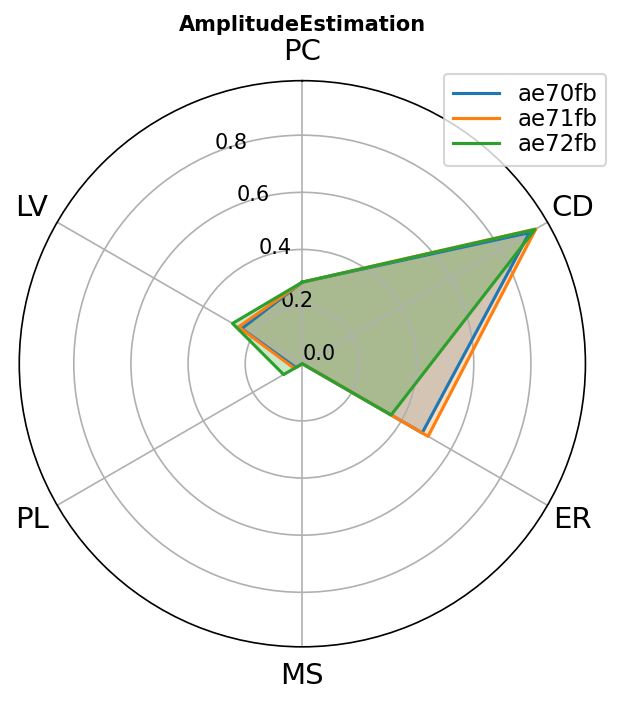

7


C:\Users\User\AppData\Local\Temp\ipykernel_17600\2142779798.py:16: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( fake_7q_pulse_v1 ) in the `backend` parameter in a future release no earlier than 2.0. `BackendV1` is deprecated and implementations should move to `BackendV2`.
  tqc = transpile(circuit, back)
C:\Users\User\AppData\Local\Temp\ipykernel_17600\2142779798.py:22: DeprecationWarning:  from_backend using V1 based backend is deprecated as of Aer 0.15 and will be removed no sooner than 3 months from that release date. Please use backends based on V2.
  pass_manager = generate_preset_pass_manager(3, AerSimulator.from_backend(back))


-1.0


C:\Users\User\AppData\Local\Temp\ipykernel_17600\2142779798.py:34: DeprecationWarning:  from_backend using V1 based backend is deprecated as of Aer 0.15 and will be removed no sooner than 3 months from that release date. Please use backends based on V2.
  noise_model = noise_model = NoiseModel.from_backend(back) #AerSimulator.from_backend(back)


0.0026627604784026527


In [7]:
# AmplitudeEstimation
#from amplitude_estimation.qiskit import ae_benchmark as aeb
import amp_est as aeb

num_state_qubits = NUM_QUBITS - 2
num_counting_qubits = NUM_QUBITS - num_state_qubits - 1

s_range = [1] # np.random.choice(2**(num_counting_qubits), NUM_CIRCUITS, False)
s_int = s_range[0]
a_ = aeb.a_from_s_int(s_int, num_counting_qubits)

print(num_state_qubits, num_counting_qubits, a_)
circ = aeb.AmplitudeEstimation(num_state_qubits, num_counting_qubits, a_)
generateResult(circ, 'ae', 'AmplitudeEstimation')
print(circ.num_qubits)
noise_sim(ideal_sim(circ))
#noise_sim()

{'0': 0.5, '1': 0.5} functools.partial(<function power_f at 0x0000025C1DD21D30>, power=2, num_state_qubits=1) 1 5


C:\Users\User\AppData\Local\Temp\ipykernel_17600\2720901843.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  mq_gates = [x[0].name for x in circ.data if x[0].num_qubits > 2 and x[0].name != 'barrier']
C:\Users\User\AppData\Local\Temp\ipykernel_17600\2720901843.py:18: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  mq_gates = [x[0].name for x in circ.data if x[0].num_qubits > 2 and x[0].name != 'barrier']
C:\Users\User\AppData\Local\Temp\ipykernel_17600\1440832730.py:11: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( aer_simulator_from(fake_7q_pulse_v1) ) in the `backend` parameter in a future releas

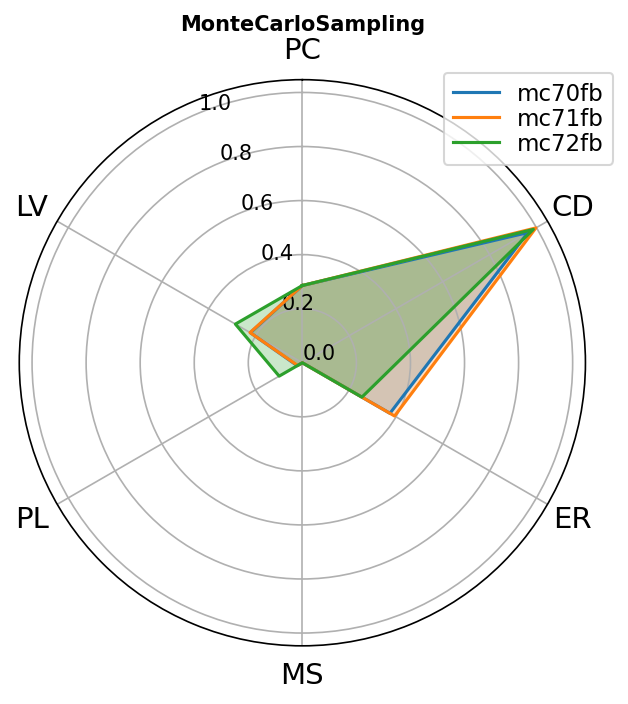

C:\Users\User\AppData\Local\Temp\ipykernel_17600\2142779798.py:16: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( aer_simulator_from(fake_7q_pulse_v1) ) in the `backend` parameter in a future release no earlier than 2.0. `BackendV1` is deprecated and implementations should move to `BackendV2`.
  tqc = transpile(circuit, back)
C:\Users\User\AppData\Local\Temp\ipykernel_17600\2142779798.py:22: DeprecationWarning:  from_backend using V1 based backend is deprecated as of Aer 0.15 and will be removed no sooner than 3 months from that release date. Please use backends based on V2.
  pass_manager = generate_preset_pass_manager(3, AerSimulator.from_backend(back))


-0.029296875000000028


C:\Users\User\AppData\Local\Temp\ipykernel_17600\2142779798.py:34: DeprecationWarning:  from_backend using V1 based backend is deprecated as of Aer 0.15 and will be removed no sooner than 3 months from that release date. Please use backends based on V2.
  noise_model = noise_model = NoiseModel.from_backend(back) #AerSimulator.from_backend(back)


-0.017653332115038577


In [10]:
import mc_benchmark_nb as mcb
import mc_utils
import functools

num_state_qubits = 1
input_size = NUM_QUBITS - 1
mu_range = [0.5] # [i/2**(input_size) for i in np.random.choice(2**(input_size), NUM_CIRCUITS, False)]
mu = mu_range[0]
target_dist = mcb.p_distribution(num_state_qubits, mu)

num_counting_qubits = NUM_QUBITS - num_state_qubits - 1

f_of_X = functools.partial(mc_utils.power_f, power=2)
f_to_estimate = functools.partial(f_of_X, num_state_qubits=num_state_qubits)

print(target_dist, f_to_estimate, num_state_qubits, num_counting_qubits)
circ = mcb.MonteCarloSampling(target_dist, f_to_estimate, num_state_qubits, num_counting_qubits, epsilon=0.05, degree=2, method=2)
generateResult(circ, 'mc', 'MonteCarloSampling')
noise_sim(ideal_sim(circ))

In [9]:
# ShorsAlgorithm
import shor_b
#from shor_b import ShorsAlgorithm
#import shors_utils
#from shors_utils import getAngles, getAngle, modinv, generate_base, verify_order

num_bits = int((NUM_QUBITS -3)/2)
base = 1
while base == 1:
  # Ensure N is a number using the greatest bit
  number = np.random.randint(2 ** (num_bits - 1) + 1, 2 ** num_bits)
  order = np.random.randint(2, number)
  base = shor_b.generate_base(number, order)

print(number, base)
circ = shor_b.ShorsAlgorithm(number, base, method=1, verbose=False)

generateResult(circ, 's', 'ShorsAlgorithm')

3 2


C:\Users\User\AppData\Local\Temp\ipykernel_17600\2720901843.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  mq_gates = [x[0].name for x in circ.data if x[0].num_qubits > 2 and x[0].name != 'barrier']
C:\Users\User\AppData\Local\Temp\ipykernel_17600\2720901843.py:18: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  mq_gates = [x[0].name for x in circ.data if x[0].num_qubits > 2 and x[0].name != 'barrier']
C:\Users\User\AppData\Local\Temp\ipykernel_17600\1440832730.py:11: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( aer_simulator_from(fake_7q_pulse_v1) ) in the `backend` parameter in a future releas

CircuitTooWideForTarget: 'Number of qubits (10) in main is greater than maximum (7) in the coupling_map'

In [ ]:
from qiskit.circuit import QuantumCircuit, Qubit
 
qc = QuantumCircuit(4, 4)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure([0, 1, 2], [0, 1, 2])

In [ ]:
qc.draw()

In [ ]:
qc.num_qubits

In [ ]:
dag1 = qiskit.converters.circuit_to_dag(qc)

In [ ]:
dag1.draw()

In [ ]:
print([x._index for x in dag1.idle_wires()])